In [1]:
import torch
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.optim as optim
from tqdm import tqdm

In [2]:
input_dir = '/kaggle/input/task1-24'

In [3]:
decays=['SinglePhotonPt50_IMGCROPS_n249k_RHv1','SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays):
    global input_dir

    dsets = [h5py.File(input_dir+'/'+decay+'.hdf5') for decay in decays]

    X = np.concatenate([dset['/X'] for dset in dsets]) 
    y = np.concatenate([dset['/y'] for dset in dsets])
    assert len(X) == len(y)

    return X, y

In [4]:
X,y=load_data(decays)
X = X.astype('float32') / 255.0
print(X.shape, y.shape)
X=X.transpose(0,3,1,2)

(498000, 32, 32, 2) (498000,)


In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=17)

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
X_train=(torch.tensor(X_train,dtype=torch.float32));
X_test=torch.tensor(X_test,dtype=torch.float32);
y_train=torch.tensor(y_train,dtype=torch.float32);
y_test=torch.tensor(y_test,dtype=torch.float32);

In [8]:
class train_dset(Dataset):
    
    def __init__(self,X,y):
        
        self.X=X
        self.y=y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        
        return self.X[idx],self.y[idx]

In [9]:
traindset= train_dset(X_train,y_train)

In [10]:
train_loader= DataLoader(traindset,batch_size=256,shuffle=True)
valdset= train_dset(X_test,y_test)
valid_loader= DataLoader(traindset,batch_size=32,shuffle=True)

In [11]:
class ResNetBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels * ResNetBlock.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * ResNetBlock.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * ResNetBlock.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * ResNetBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * ResNetBlock.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet15(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet15, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

def resnet15():
    return ResNet15(ResNetBlock, [2, 2, 2, 1], num_classes=2)

model = resnet15()
print(model)

ResNet15(
  (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

Epoch 1/100: 100%|██████████| 1557/1557 [00:50<00:00, 31.05it/s, loss=0.6487]


Validation Accuracy: 66.48%
VAL LOSS 0.6248022351997444
Model parameters saved


Epoch 2/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.77it/s, loss=0.5921]


Validation Accuracy: 70.10%
VAL LOSS 0.5814248332297467
Model parameters saved


Epoch 3/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.50it/s, loss=0.5810]


Validation Accuracy: 70.62%
VAL LOSS 0.5761805608042752
Model parameters saved


Epoch 4/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.71it/s, loss=0.5785]


Validation Accuracy: 70.54%
VAL LOSS 0.5789472480255916


Epoch 5/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.72it/s, loss=0.5706]


Validation Accuracy: 71.19%
VAL LOSS 0.5701333442557768
Model parameters saved


Epoch 6/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.69it/s, loss=0.5664]


Validation Accuracy: 70.35%
VAL LOSS 0.5755361403207703


Epoch 7/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.65it/s, loss=0.5638]


Validation Accuracy: 71.56%
VAL LOSS 0.562363235069566
Model parameters saved


Epoch 8/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.68it/s, loss=0.5602]


Validation Accuracy: 69.94%
VAL LOSS 0.5811026369089104


Epoch 9/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.74it/s, loss=0.5585]


Validation Accuracy: 71.83%
VAL LOSS 0.5612486721018711
Model parameters saved


Epoch 10/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.61it/s, loss=0.5567]


Validation Accuracy: 72.25%
VAL LOSS 0.5552245756445161
Model parameters saved


Epoch 11/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.53it/s, loss=0.5549]


Validation Accuracy: 72.49%
VAL LOSS 0.552205709408086
Model parameters saved


Epoch 12/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.48it/s, loss=0.5536]


Validation Accuracy: 72.35%
VAL LOSS 0.5524907271498178


Epoch 13/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.63it/s, loss=0.5518]


Validation Accuracy: 72.49%
VAL LOSS 0.5519434210502479
Model parameters saved


Epoch 14/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.78it/s, loss=0.5506]


Validation Accuracy: 72.77%
VAL LOSS 0.5533749504692583


Epoch 15/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.64it/s, loss=0.5497]


Validation Accuracy: 72.74%
VAL LOSS 0.5481765819290076
Model parameters saved


Epoch 16/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.75it/s, loss=0.5485]


Validation Accuracy: 72.71%
VAL LOSS 0.5504423090875388


Epoch 17/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.80it/s, loss=0.5476]


Validation Accuracy: 72.54%
VAL LOSS 0.5502169950731308


Epoch 18/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.74it/s, loss=0.5466]


Validation Accuracy: 72.52%
VAL LOSS 0.552760998254799


Epoch 19/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.65it/s, loss=0.5456]


Validation Accuracy: 73.14%
VAL LOSS 0.5433026764299496
Model parameters saved


Epoch 20/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.78it/s, loss=0.5448]


Validation Accuracy: 72.94%
VAL LOSS 0.5455859466465601


Epoch 21/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.64it/s, loss=0.5442]


Validation Accuracy: 72.37%
VAL LOSS 0.5507934770574532


Epoch 22/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.38it/s, loss=0.5434]


Validation Accuracy: 73.21%
VAL LOSS 0.5412512985554087
Model parameters saved


Epoch 23/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.78it/s, loss=0.5428]


Validation Accuracy: 72.95%
VAL LOSS 0.5465211545272046


Epoch 24/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.82it/s, loss=0.5420]


Validation Accuracy: 71.99%
VAL LOSS 0.5562260487855198


Epoch 25/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.77it/s, loss=0.5412]


Validation Accuracy: 73.42%
VAL LOSS 0.5392252399308615
Model parameters saved


Epoch 26/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.18it/s, loss=0.5405]


Validation Accuracy: 72.85%
VAL LOSS 0.5460323387145039


Epoch 27/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.79it/s, loss=0.5398]


Validation Accuracy: 73.01%
VAL LOSS 0.5472645206049265


Epoch 28/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.58it/s, loss=0.5390]


Validation Accuracy: 70.89%
VAL LOSS 0.5707740216202525


Epoch 29/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.53it/s, loss=0.5381]


Validation Accuracy: 73.57%
VAL LOSS 0.5391745297006335
Model parameters saved


Epoch 30/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.68it/s, loss=0.5372]


Validation Accuracy: 70.66%
VAL LOSS 0.5689475093859745


Epoch 31/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.85it/s, loss=0.5365]


Validation Accuracy: 73.71%
VAL LOSS 0.5342880853304423
Model parameters saved


Epoch 32/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.77it/s, loss=0.5357]


Validation Accuracy: 73.93%
VAL LOSS 0.5314864061395806
Model parameters saved


Epoch 33/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.61it/s, loss=0.5348]


Validation Accuracy: 73.27%
VAL LOSS 0.5422045154073631


Epoch 34/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.53it/s, loss=0.5341]


Validation Accuracy: 73.91%
VAL LOSS 0.5298664232382334
Model parameters saved


Epoch 35/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.76it/s, loss=0.5325]


Validation Accuracy: 74.09%
VAL LOSS 0.5291359571256791
Model parameters saved


Epoch 36/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.86it/s, loss=0.5312]


Validation Accuracy: 74.10%
VAL LOSS 0.5285029813300175
Model parameters saved


Epoch 37/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.88it/s, loss=0.5297]


Validation Accuracy: 74.37%
VAL LOSS 0.5249031470602296
Model parameters saved


Epoch 38/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.62it/s, loss=0.5283]


Validation Accuracy: 74.01%
VAL LOSS 0.5304503122175553


Epoch 39/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.51it/s, loss=0.5275]


Validation Accuracy: 74.59%
VAL LOSS 0.5204340561757604
Model parameters saved


Epoch 40/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.76it/s, loss=0.5256]


Validation Accuracy: 74.70%
VAL LOSS 0.5188804630582112
Model parameters saved


Epoch 41/100: 100%|██████████| 1557/1557 [00:48<00:00, 31.89it/s, loss=0.5236]


Validation Accuracy: 74.55%
VAL LOSS 0.5212169805037449


Epoch 42/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.67it/s, loss=0.5219]


Validation Accuracy: 74.96%
VAL LOSS 0.5151671526039461
Model parameters saved


Epoch 43/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.50it/s, loss=0.5202]


Validation Accuracy: 74.95%
VAL LOSS 0.516704078582396


Epoch 44/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.63it/s, loss=0.5180]


Validation Accuracy: 75.00%
VAL LOSS 0.5132674221700454
Model parameters saved


Epoch 45/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.70it/s, loss=0.5157]


Validation Accuracy: 74.76%
VAL LOSS 0.516327121217088


Epoch 46/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.54it/s, loss=0.5142]


Validation Accuracy: 75.12%
VAL LOSS 0.5145665846723151


Epoch 47/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.66it/s, loss=0.5111]


Validation Accuracy: 75.57%
VAL LOSS 0.5021793938233671
Model parameters saved


Epoch 48/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.68it/s, loss=0.5084]


Validation Accuracy: 75.72%
VAL LOSS 0.5016016201226108
Model parameters saved


Epoch 49/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.40it/s, loss=0.5063]


Validation Accuracy: 75.68%
VAL LOSS 0.5018607098869531


Epoch 50/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.20it/s, loss=0.5033]


Validation Accuracy: 75.88%
VAL LOSS 0.49904596384749356
Model parameters saved


Epoch 51/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.39it/s, loss=0.5007]


Validation Accuracy: 76.04%
VAL LOSS 0.4988877097167164
Model parameters saved


Epoch 52/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.71it/s, loss=0.4975]


Validation Accuracy: 76.19%
VAL LOSS 0.49314767559249717
Model parameters saved


Epoch 53/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.69it/s, loss=0.4944]


Validation Accuracy: 76.29%
VAL LOSS 0.49478981559654794


Epoch 54/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.56it/s, loss=0.4915]


Validation Accuracy: 76.91%
VAL LOSS 0.4824931853231656
Model parameters saved


Epoch 55/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.63it/s, loss=0.4883]


Validation Accuracy: 76.80%
VAL LOSS 0.48184763990013474
Model parameters saved


Epoch 56/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.50it/s, loss=0.4850]


Validation Accuracy: 77.35%
VAL LOSS 0.4739610567665004
Model parameters saved


Epoch 57/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.64it/s, loss=0.4817]


Validation Accuracy: 77.22%
VAL LOSS 0.47208080351233006
Model parameters saved


Epoch 58/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.48it/s, loss=0.4785]


Validation Accuracy: 77.75%
VAL LOSS 0.4668126268080439
Model parameters saved


Epoch 59/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.46it/s, loss=0.4758]


Validation Accuracy: 77.60%
VAL LOSS 0.46920376521157453


Epoch 60/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.71it/s, loss=0.4723]


Validation Accuracy: 78.15%
VAL LOSS 0.4585331719946191
Model parameters saved


Epoch 61/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.68it/s, loss=0.4698]


Validation Accuracy: 77.04%
VAL LOSS 0.4782900764437086


Epoch 62/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.53it/s, loss=0.4654]


Validation Accuracy: 78.41%
VAL LOSS 0.4552701862138438
Model parameters saved


Epoch 63/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.72it/s, loss=0.4628]


Validation Accuracy: 77.72%
VAL LOSS 0.46556333069341727


Epoch 64/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.47it/s, loss=0.4599]


Validation Accuracy: 78.07%
VAL LOSS 0.4584923901758998


Epoch 65/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.45it/s, loss=0.4570]


Validation Accuracy: 79.12%
VAL LOSS 0.4416053142593089
Model parameters saved


Epoch 66/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.64it/s, loss=0.4535]


Validation Accuracy: 79.33%
VAL LOSS 0.4378437192480727
Model parameters saved


Epoch 67/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.68it/s, loss=0.4497]


Validation Accuracy: 78.64%
VAL LOSS 0.4483649630216231


Epoch 68/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.71it/s, loss=0.4472]


Validation Accuracy: 79.18%
VAL LOSS 0.43802718674921126


Epoch 69/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.73it/s, loss=0.4440]


Validation Accuracy: 79.75%
VAL LOSS 0.4279266878208482
Model parameters saved


Epoch 70/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.58it/s, loss=0.4407]


Validation Accuracy: 80.04%
VAL LOSS 0.4253380128226606
Model parameters saved


Epoch 71/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.54it/s, loss=0.4379]


Validation Accuracy: 78.51%
VAL LOSS 0.45313221406027016


Epoch 72/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.52it/s, loss=0.4351]


Validation Accuracy: 80.55%
VAL LOSS 0.4155937864813939
Model parameters saved


Epoch 73/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.36it/s, loss=0.4320]


Validation Accuracy: 80.38%
VAL LOSS 0.4166763121978825


Epoch 74/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.29it/s, loss=0.4298]


Validation Accuracy: 80.60%
VAL LOSS 0.41327495568009265
Model parameters saved


Epoch 75/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.37it/s, loss=0.4264]


Validation Accuracy: 80.89%
VAL LOSS 0.4063302849705918
Model parameters saved


Epoch 76/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.39it/s, loss=0.4229]


Validation Accuracy: 80.93%
VAL LOSS 0.4078762285608843


Epoch 77/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.37it/s, loss=0.4209]


Validation Accuracy: 80.69%
VAL LOSS 0.4115363219907006


Epoch 78/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.19it/s, loss=0.4178]


Validation Accuracy: 80.97%
VAL LOSS 0.4071580402583004


Epoch 79/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.36it/s, loss=0.4149]


Validation Accuracy: 81.40%
VAL LOSS 0.39828109385737454
Model parameters saved


Epoch 80/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.41it/s, loss=0.4117]


Validation Accuracy: 81.57%
VAL LOSS 0.3933989692488349
Model parameters saved


Epoch 81/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.37it/s, loss=0.4094]


Validation Accuracy: 81.76%
VAL LOSS 0.3899749170046255
Model parameters saved


Epoch 82/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.19it/s, loss=0.4073]


Validation Accuracy: 81.59%
VAL LOSS 0.39391602487688565


Epoch 83/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.40it/s, loss=0.4043]


Validation Accuracy: 81.80%
VAL LOSS 0.3903451767970759


Epoch 84/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.39it/s, loss=0.4018]


Validation Accuracy: 82.33%
VAL LOSS 0.37974317365741156
Model parameters saved


Epoch 85/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.34it/s, loss=0.3999]


Validation Accuracy: 81.23%
VAL LOSS 0.4002989715888318


Epoch 86/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.30it/s, loss=0.3961]


Validation Accuracy: 82.00%
VAL LOSS 0.38686123835633557


Epoch 87/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.44it/s, loss=0.3942]


Validation Accuracy: 81.63%
VAL LOSS 0.39264570223997874


Epoch 88/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.37it/s, loss=0.3911]


Validation Accuracy: 81.56%
VAL LOSS 0.3944386924952867


Epoch 89/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.39it/s, loss=0.3892]


Validation Accuracy: 82.73%
VAL LOSS 0.3711244593806056
Model parameters saved


Epoch 90/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.24it/s, loss=0.3860]


Validation Accuracy: 81.37%
VAL LOSS 0.3979433212797326


Epoch 91/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.37it/s, loss=0.3843]


Validation Accuracy: 83.07%
VAL LOSS 0.3663971064230764
Model parameters saved


Epoch 92/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.42it/s, loss=0.3813]


Validation Accuracy: 83.19%
VAL LOSS 0.3647212438411023
Model parameters saved


Epoch 93/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.39it/s, loss=0.3794]


Validation Accuracy: 83.04%
VAL LOSS 0.36728143226190746


Epoch 94/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.23it/s, loss=0.3773]


Validation Accuracy: 83.00%
VAL LOSS 0.3670871036831873


Epoch 95/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.37it/s, loss=0.3736]


Validation Accuracy: 83.14%
VAL LOSS 0.36274191730891364
Model parameters saved


Epoch 96/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.45it/s, loss=0.3731]


Validation Accuracy: 83.85%
VAL LOSS 0.35128677918429835
Model parameters saved


Epoch 97/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.34it/s, loss=0.3702]


Validation Accuracy: 83.57%
VAL LOSS 0.3576608578950526


Epoch 98/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.26it/s, loss=0.3683]


Validation Accuracy: 83.46%
VAL LOSS 0.3551161865513009


Epoch 99/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.40it/s, loss=0.3664]


Validation Accuracy: 83.94%
VAL LOSS 0.3492181719342868
Model parameters saved


Epoch 100/100: 100%|██████████| 1557/1557 [00:49<00:00, 31.36it/s, loss=0.3649]


Validation Accuracy: 84.11%
VAL LOSS 0.34736170422121226
Model parameters saved
Finished Training


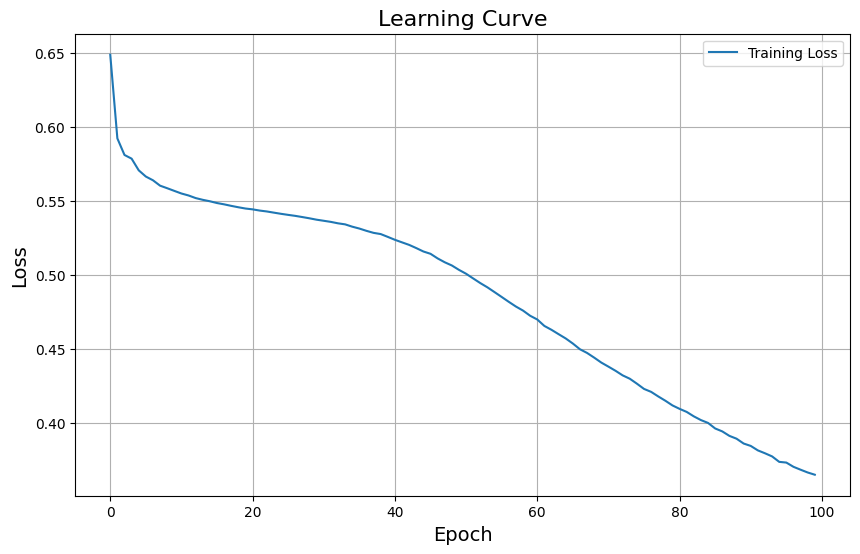

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
best_loss = 100000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, data in progress_bar:

        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{running_loss / (i + 1):.4f}")

    # Average training loss for the epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation loss
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        validation_loss = 0.0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        validation_loss /= len(valid_loader)
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')
    
    print("VAL LOSS",validation_loss)
    best_loss =  min(validation_loss , best_loss)
    if(best_loss == validation_loss):
     
        torch.save(model.state_dict(), f'model_resnet15.pth')
        print('Model parameters saved')

    scheduler.step(validation_loss)

print('Finished Training')



# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Learning Curve', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Validation

In [13]:
model.eval()  
total = 0
correct = 0


with torch.no_grad():  
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 84.11%
